In [ ]:
%matplotlib inline
bs = 32
version = 1

In [ ]:
!pip install -Uqq fastai

In [ ]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/yoga_pose_recognizer

/content/drive/My Drive/yoga_pose_recognizer


In [ ]:
data_path = "data"
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # getting 90-10 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))                            # resizing to get the image of same shape

In [ ]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path, bs = bs)
torch.save(dls, f"yoga_pose_dataloader_v{version}.pkl")

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


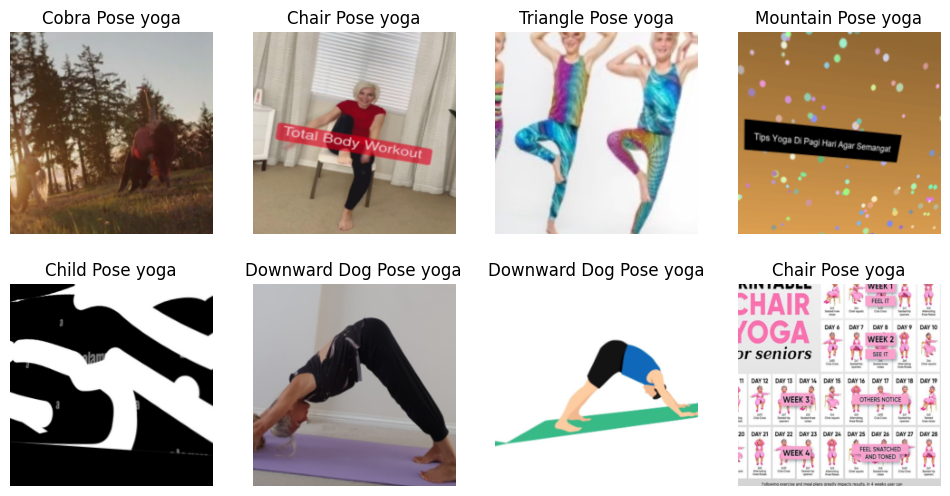

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

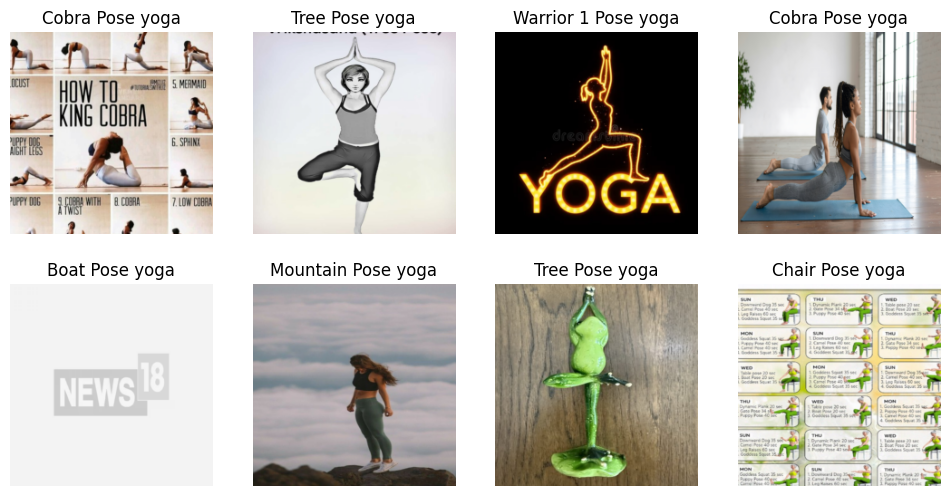

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

In [ ]:
model_path = "models"

In [ ]:
model = vision_learner(dls, efficientnet_b0, metrics=[error_rate,accuracy])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.568740,1.477160,0.435606,0.564394,09:08


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.512401,0.958190,0.299242,0.700758,11:56
1,1.365366,0.858206,0.265152,0.734848,11:59
2,1.105279,0.618072,0.196970,0.803030,11:54
3,0.932838,0.554056,0.185606,0.814394,11:53
4,0.823099,0.577561,0.178030,0.821970,11:57


In [ ]:
model.save(f"yoga_pose-recognizer-v{version}")

Path('models/yoga_pose-recognizer-v1.pth')

In [ ]:
#model.load(f"yoga_pose-recognizer-v{version}")

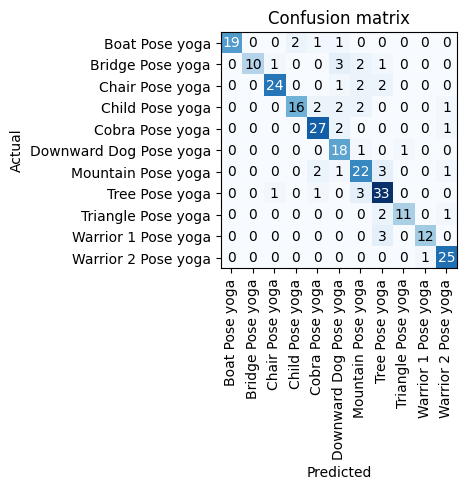

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


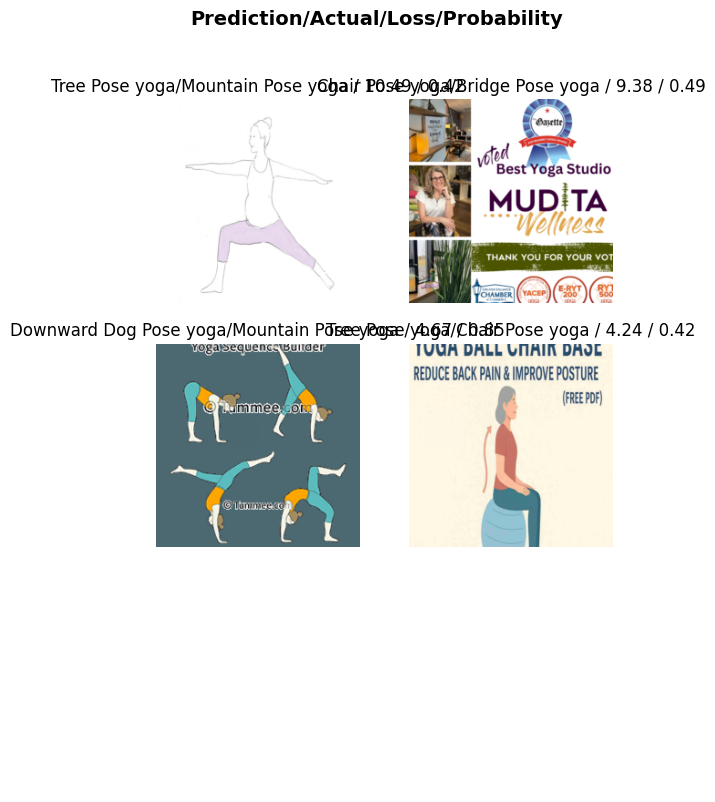

In [ ]:
interp.plot_top_losses(4, nrows=3)

In [ ]:
cleaner = ImageClassifierCleaner(model)
cleaner

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink(missing_ok=True)                                   # delete irrelevant data
# #for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), f"{data_path}/{cat}") # change the directory

In [ ]:
import shutil
from pathlib import Path

# Assuming data_path is defined
for idx, cat in cleaner.change():
    source_path = cleaner.fns[idx]
    dest_folder = Path(data_path) / cat
    dest_path = dest_folder / source_path.name # Full destination path

    # Check if the source file exists AND if the destination file does NOT exist
    if source_path.exists():
        if dest_path.exists():
            print(f"Skipping move: File already exists at {dest_path}")
            continue # Skip to the next iteration

        # If it doesn't exist at the destination, perform the move
        dest_folder.mkdir(parents=True, exist_ok=True)
        shutil.move(str(source_path), str(dest_folder))
    else:
        print(f"Skipping move: Source file not found at {source_path}")

In [ ]:
model.export(f"{model_path}/yoga-pose-recognizer-v{version}.pkl")